Demo Goals
------
What I'd like to do is:
- Read an image from the butler
- Inspect some header-like aspects, see basic metadata
- Display the image data
- Overplot a catalog

Initial Setup
------
This also borrows from the packages loaded in the catalog demo.

In [3]:
import numpy as np
import lsst.afw.image as afwImage
import lsst.daf.persistence as dafPersist

repo_dir = "/raid/ctslater/decam_NEO_repo"
b = dafPersist.Butler(repo_dir)

Let's get an image from the butler now.

In [82]:
img = b.get("calexp", visit=197828, ccdnum=9)

Trying to display an image
---------

In [84]:
print img

<lsst.afw.image.imageLib.ExposureF; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::image::Exposure< float,lsst::afw::image::MaskPixel,lsst::afw::image::VariancePixel > > *' at 0x7f7d144283f0> >


We have an Exposure, which might differ from other image-like types.

In [85]:
d = img.getDetector()
print d

<lsst.afw.cameraGeom.cameraGeomLib.Detector; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::cameraGeom::Detector > *' at 0x7f7d15597390> >


Neither of those were very informative. Neither `img.getArray()` nor `d.getArray()` exist, so it's not clear where I should go from here. More experiments with tab-completion follow:

In [86]:
cal = img.getCalib()
cal.getExptime()

60.0

At least we got something out.


In [87]:
wcs = img.getWcs()
print wcs

<lsst.afw.image.imageLib.Wcs; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::image::Wcs > *' at 0x7f7d15597720> >


Wcs is there, but not sure what to do with it. I'll come back to this later.

*a long process of trial and error with tab completion ensued here*

In [88]:
masked_img = img.getMaskedImage()

A breakthrough! `MaskedImage` seems to be more specific than `Exposure`, so maybe we're getting closer to finding the data? Tab complete leads us to:

In [89]:
help(masked_img.getArrays)

Help on method getArrays in module lsst.afw.image.imageLib:

getArrays(self) method of lsst.afw.image.imageLib.MaskedImageF instance
    Return a tuple (value, mask, variance) numpy arrays.



That sounds good. Let's see it.

In [90]:
masked_img.getArrays()

(array([[-390.00744629, -390.00247192, -389.99752808, ..., -390.10351562,
         -390.10461426, -390.10574341],
        [-390.00424194, -389.99935913, -389.99438477, ..., -390.10256958,
         -390.10366821, -390.10476685],
        [-390.00106812, -389.99615479, -389.99124146, ..., -390.10162354,
         -390.10269165, -390.10375977],
        ..., 
        [-391.36993408, -391.37039185, -391.37088013, ..., -391.71640015,
         -391.71917725, -391.72195435],
        [-391.37033081, -391.37081909, -391.37124634, ..., -391.71737671,
         -391.72015381, -391.72299194],
        [-391.37075806, -391.37121582, -391.37167358, ..., -391.71835327,
         -391.72119141, -391.72396851]], dtype=float32),
 array([[17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        ..., 
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17]], dtype=uint16),
 array([[  1.00000000

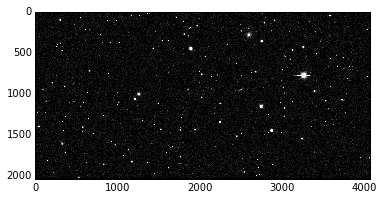

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
img_arr, mask_arr, var_arr = masked_img.getArrays()
plt.imshow(np.rot90(img_arr), vmin=0, vmax=100, cmap='gray')

**An image!**

Working with WCS
---------
Ok, back to WCS. It would be fun to first check that we can determine say, the RA and Dec center of the image, since that's a self-contained problem. Then, we could also load a catalog, and try to overplot the detected sources. Let's tab-complete like wild:

In [92]:
wcs = img.getWcs()

In [93]:
print wcs.pixelToSky(0,0)
print wcs.pixelToSky(img.getWidth()/2, img.getHeight()/2)

IcrsCoord(196.2957764, -17.7939929)
IcrsCoord(196.4514711, -17.8685556)


I'm not sure which is width and which is height yet. I'll try to deduce that later.

In [94]:
img.getWidth(), img.getHeight()

(2032, 4076)

In [95]:
cat = b.get("src", visit=197828, ccdnum=9)

In [96]:
s = cat[0]
s.getCoord()

IcrsCoord(196.29648202282982 * afwGeom.degrees, -17.839162435714822 * afwGeom.degrees)

This will give us a coordinate for an individual source. It doesn't seem to work on the entire catalog (`cat.getCoord()` fails, as does `cat.getRa()` or `cat.getDec()`.) That will do for now though, to test running it through WCS.

In [97]:
help(wcs.skyToPixel)

Help on method skyToPixel in module lsst.afw.image.imageLib:

skyToPixel(self, *args) method of lsst.afw.image.imageLib.Wcs instance
    skyToPixel(Wcs self, Angle sky1, Angle sky2) -> Point2D
    skyToPixel(Wcs self, Coord coord) -> Point2D



Perfect, it's overloaded to take either two coordinates or a `Coord` object.

In [98]:
wcs.skyToPixel(s.getCoord())

Point2D(620, 12)

Let's be unsophisticated and just loop through all of these and throw them on the image.

(0, 2032)

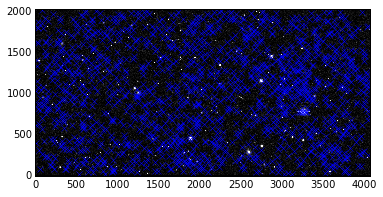

In [99]:
plt.imshow(np.rot90(img_arr), vmin=0, vmax=100, cmap='gray')
for source in cat:
    point = wcs.skyToPixel(source.getCoord())
    plt.plot(point.getY(), point.getX(), 'bx')
plt.xlim(0, img.getHeight())
plt.ylim(0, img.getWidth())

It works!

(But obviously I had x and y switched the first time I did this, and have been relying on tab complete to tell me how to use things like `Point2D`)